In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Flatten, concatenate, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
class ExpWeight(Layer):

  def __init__(self, alpha=1., beta=1.):
    super(ExpWeight, self).__init__()
    self.alpha = alpha
    self.beta = beta

  def build(self, input_shape):
    w_plus_init = tf.random_uniform_initializer(minval=0., maxval=1.)
    w_negative_init = tf.random_uniform_initializer(minval=0., maxval=1.)
    b_plus_init = tf.zeros_initializer()
    b_negative_init = tf.zeros_initializer()

    self.w_plus = tf.Variable(name='w_plus',
                              initial_value=w_plus_init(shape=(1, input_shape[-1]),
                                                        dtype='float32'),
                              trainable=True)
    self.w_negative = tf.Variable(name='w_negative',
                              initial_value=w_negative_init(shape=(1, input_shape[-1]),
                                                        dtype='float32'),
                              trainable=True)
    self.b_plus = tf.Variable(name='b_plus',
                              initial_value=b_plus_init(shape=(1,),
                                                        dtype='float32'),
                              trainable=True)
    self.b_negative = tf.Variable(name='b_negative',
                              initial_value=b_negative_init(shape =(1, ),
                                                        dtype='float32'),
                              trainable=True)
    super().build(input_shape)

  def call(self, inputs):
    w_plus = self.w_plus * tf.cast(tf.math.greater_equal(self.w_plus, 0.), self.w_plus.dtype)
    w_negative = self.w_negative * tf.cast(tf.math.greater_equal(self.w_negative, 0.), self.w_negative.dtype)
    b_plus = self.b_plus * tf.cast(tf.math.greater_equal(self.b_plus, 0.), self.b_plus.dtype)
    b_negative = self.b_negative * tf.cast(tf.math.greater_equal(self.b_negative, 0.), self.b_negative.dtype)
    plus = tf.reduce_sum(tf.math.exp(self.alpha*(inputs-w_plus)), 1) + tf.math.exp(self.alpha*(1.-b_plus))
    negative = tf.reduce_sum(tf.math.exp(self.alpha*(inputs-w_negative)), 1) + tf.math.exp(self.alpha*(1.-b_negative))
    result = self.beta*tf.math.log(plus/negative)
    return tf.expand_dims(result, axis=-1)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/100
480/480 [==============================] - 243s 266ms/step - loss: 0.8090 - accuracy: 0.7729 - val_loss: 0.2916 - val_accuracy: 0.9184
Epoch 2/100
480/480 [==============================] - 112s 234ms/step - loss: 0.2831 - accuracy: 0.9157 - val_loss: 0.2131 - val_accuracy: 0.9371
Epoch 3/100
480/480 [==============================] - 113s 235ms/step - loss: 0.1974 - accuracy: 0.9396 - val_loss: 0.1833 - val_accuracy: 0.9443
Epoch 4/100
480/480 [==============================] - 113s 235ms/step - loss: 0.1528 - accuracy: 0.9533 - val_loss: 0.1622 - val_accuracy: 0.9503
Epoch 5/100
480/480 [==============================] - 110s 229ms/step - loss: 0.1226 - accuracy: 0.9624 - val_loss: 0.1474 - val_accuracy: 0.9563
Epoch 6/100
480/480 [==============================] - 108s 224ms/step - loss: 0.0997 - accuracy: 0.9688 - val_loss: 0.1410 - val_accuracy: 0.9573
Epoch 7/100
480/480 [==============================] 

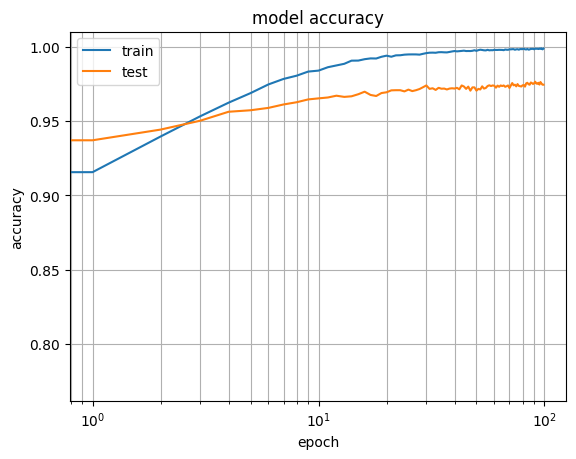

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

inputs = Input(shape=(28,28))
x = Flatten()(inputs)
x = concatenate([ExpWeight(alpha=4.35, beta=4.0)(x) for _ in range(300)], axis=-1)
x = Dropout(0.2)(x)
x = concatenate([ExpWeight(alpha=4.35, beta=4.0)(x) for _ in range(10)], axis=-1)
output = Activation('softmax')(x)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=125, validation_data =(x_test, y_test),
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)])

plt.grid(True, which="both")
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()